## Setup

In [1]:
%matplotlib inline

In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo
from aif360.metrics import BinaryLabelDatasetMetric
from oversample import label_bias, selection_bias 
from sklearn import preprocessing
from privacy_meter.dataset import Dataset
from aif360.datasets import BinaryLabelDataset
import os
import shutil
import glob
from datetime import datetime

## Arguments & Initializations

In [3]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade', 'law_sex', 'law_race', 'law_aif_gender', 'law_aif_race'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")
ap.add_argument("-a", "--attack", choices=['mia1', 'mia2'], default='mia1', help="attacks: our implementation, their implementation")

_StoreAction(option_strings=['-a', '--attack'], dest='attack', nargs=None, const=None, default='mia1', type=None, choices=['mia1', 'mia2'], required=False, help='attacks: our implementation, their implementation', metavar=None)

In [4]:
sys.argv = ['']
args = vars(ap.parse_args())

In [5]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2,
 'attack': 'mia1'}

In [6]:
DATASET = "compas_race"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = 1
ATTACK = "mia2"

In [7]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 20

# cpp_metrics = defaultdict(list) 
# cpp_mia_metrics = defaultdict(list)

# pr_orig_metrics = defaultdict(list) 
# ro_metrics = defaultdict(list) 

In [8]:
# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

eg_metrics = defaultdict(list) 
eg_mia_metrics = defaultdict(list) 

## Loading & Splitting Dataset

In [9]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

In [10]:
dataset_orig.features.shape

(6172, 10)

In [11]:
privileged_groups

[{'race': 1}]

In [12]:
sens_attr

'race'

In [13]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

In [14]:
df, _ = dataset_orig.convert_to_dataframe()

In [15]:
df[['race','two_year_recid']].value_counts()

race  two_year_recid
0.0   0.0               2082
      1.0               1987
1.0   0.0               1281
      1.0                822
Name: count, dtype: int64

In [16]:
if ATTACK == "mia1":
    # training data split ratio
    p = 0.5
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print(dataset_orig_train.features)

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')
        
    dataset_orig_train
    dataset_orig_train?

## Run Mitigating Algorithms

### Setup for MIA2

In [17]:
seed = 1234
np.random.seed(seed)

In [18]:
if ATTACK == "mia2":
    # prepare data format
    X = dataset_orig.features
    y_true = dataset_orig.labels.ravel()
    sens_attr = dataset_orig.protected_attribute_names[0]
    sens_attr_index = dataset_orig.feature_names.index(sens_attr)
    sensitive_features = dataset_orig.features[:, sens_attr_index]

    X_other_features = np.delete(X, sens_attr_index, axis=1)
    X_other_features_normalized = preprocessing.normalize(X_other_features, norm='l2')

    # Reconstruct X by combining the sensitive attribute and the normalized features
    # Insert the sensitive attribute back into its original position
    X_normalized = np.insert(X_other_features_normalized, sens_attr_index, sensitive_features, axis=1)
    X = X_normalized

In [19]:
def get_unique_indices_reference():
    # Determine split sizes proportionally (to sum up to the full dataset size)
    num_train_points = int(X.shape[0] * 0.12)
    num_test_points = int(X.shape[0] * 0.12)
    num_population_points = int(X.shape[0] * 0.3)  # Reduced from 30000

    # Start with all indices
    all_indices = np.arange(X.shape[0])

    # Select train indices without replacement
    train_index = np.random.choice(all_indices, num_train_points, replace=False)
    # Remove train indices from available indices
    remaining_indices = np.setdiff1d(all_indices, train_index)

    # Select test indices from the remaining indices without replacement
    test_index = np.random.choice(remaining_indices, num_test_points, replace=False)
    # Remove test indices from available indices
    remaining_indices = np.setdiff1d(remaining_indices, test_index)

    # Select population indices from the remaining indices (can also choose all remaining points)
    population_index = np.random.choice(remaining_indices, min(num_population_points, len(remaining_indices)), replace=False)
    
    # Summary of counts
    print("==============================================================")
    print("GET UNIQUE INDICES REFERENCE")
    print(f"Number of train points: {len(train_index)}")
    print(f"Number of test points: {len(test_index)}")
    print(f"Number of population points: {len(population_index)}")
    print("==============================================================")
    
    return train_index, test_index, population_index

In [20]:
def create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train):
    # create the target model's dataset
    train_ds = {'x': X[train_index], 'y': y_true[train_index],'g':g_train}
    test_ds = {'x': X[test_index], 'y': y_true[test_index], 'g':g_test}
    target_dataset = Dataset(
        data_dict={'train': train_ds, 'test': test_ds},
        default_input='x', default_output='y', default_group='g'
    )

    # create the reference dataset
    population_ds = {'x': X[population_index], 'y': y_true[population_index], 'g': g_pop_train}
    reference_dataset = Dataset(
        data_dict={'train': population_ds},
        default_input='x', default_output='y', default_group='g'
    )
    
    return target_dataset, reference_dataset

In [21]:
# Combine features, labels, and protected attributes into a DataFrame
def create_binary_label_dataset(dataset_orig, X, y, sensitive_features, sens_attr_name, privileged_value, unprivileged_value):
    print("=====================================================")
    print("CREATE BINARY LABEL DATASET")
    # Extract the feature names from the original dataset
    feature_names = dataset_orig.feature_names

    # Create a DataFrame with features, labels, and sensitive attribute
    df = pd.DataFrame(X, columns=feature_names)
    df[dataset_orig.label_names[0]] = y
#     print(df.head())
    # print(dataset_orig.feature_names)
    # print(dataset_orig.features.shape)
    
    # df_orig, _ = dataset_orig.convert_to_dataframe()

    # # Display the first few rows
    # print("Original df's head:", df_orig.head())
    
    # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset_orig.labels, return_counts=True)

    # # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")

    # Create the BinaryLabelDataset
    dataset = BinaryLabelDataset(
        favorable_label=1.0,  # Adjust as per your dataset
        unfavorable_label=0.0,  # Adjust as per your dataset
        df=df,  # DataFrame containing features, labels, and protected attribute
        label_names=dataset_orig.label_names,  # Column name of labels in DataFrame
        protected_attribute_names=[sens_attr_name],  # Protected attribute column
        privileged_protected_attributes=[privileged_value],  # Privileged group values
        unprivileged_protected_attributes=[unprivileged_value]  # Unprivileged group values
    )
    
    # print(dataset.feature_names)
    # print(dataset.features.shape)
    # # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset.labels, return_counts=True)

    # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")
    
    print("=====================================================")
    
    return dataset

In [22]:
def delete_logs():
    # Search for directories ending with _group or _pop
    for pattern in ["*_group", "*_pop"]:
        # Find matching directories
        for log_dir in glob.glob(pattern):
            if os.path.exists(log_dir) and os.path.isdir(log_dir):  # Ensure it's a directory
                shutil.rmtree(log_dir)
                print(f"{log_dir} deleted.")

### Calling Both

In [23]:
# target_dataset = None
# reference_dataset = None

In [24]:
import warnings
warnings.filterwarnings("ignore")

In [25]:
def prepare_datasets():
    target_dataset = None
    reference_dataset = None
    
    if ATTACK == "mia1":
        # split dataset into train, validation, and test
        dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
        dataset_orig_val = dataset_orig_test

    elif ATTACK == "mia2":
        train_index, test_index, population_index = get_unique_indices_reference()

        g_train = y_true[train_index] + (sensitive_features[train_index] + 1) * 2 # 2, 4, 3, 5
        g_test = y_true[test_index] + (sensitive_features[test_index] + 1) * 2
        g_pop_train = y_true[population_index] + (sensitive_features[population_index] + 1) * 2

        # for Audit
        target_dataset, reference_dataset = create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train)

        # for mitigators
        privileged_value = [1]
        unprivileged_value = [0]
        # Convert train dataset
        dataset_orig_train = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[train_index],
            y=y_true[train_index],
            sensitive_features=sensitive_features[train_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
#         dataset_orig_val = create_binary_label_dataset(
#             dataset_orig=dataset_orig,
#             X=X[valid_index],
#             y=y_true[valid_index],
#             sensitive_features=sensitive_features[valid_index],
#             sens_attr_name=sens_attr,
#             privileged_value=privileged_value,
#             unprivileged_value=unprivileged_value
#         )

        # Convert test dataset
        dataset_orig_test = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[test_index],
            y=y_true[test_index],
            sensitive_features=sensitive_features[test_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
        dataset_orig_val = dataset_orig_test
        
    return dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset

In [26]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

try:
    # run mitigating algorithms
    for i in range(N):
        print('ITERATION ', i)
        dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()

        # check fairness on the original data
        metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
        print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
        base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
        base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        print("DIFFERENCE IS GOOD")
        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        # favorable and unfavorable labels and feature_names
        f_label = dataset_orig.favorable_label
        uf_label = dataset_orig.unfavorable_label
        feature_names = dataset_orig.feature_names

        # introduce label or selection biases, assuming the original data is fair
        if BIAS_TYPE == 'label':
            dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
        elif BIAS_TYPE == 'selection':
            dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
        else:
            print('no bias type specified')

        # show data info
        print("#### Training Dataset shape")
        print(dataset_orig_train.features.shape)
        print("#### Favorable and unfavorable labels")
        print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
        print("#### Protected attribute names")
        print(dataset_orig_train.protected_attribute_names)
        print("#### Privileged and unprivileged protected groups")
        print(privileged_groups, unprivileged_groups)
        print("#### Privileged and unprivileged protected attribute values")
        print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
        print("#### Dataset feature names")
        print(dataset_orig_train.feature_names)
        print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
        print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

        # statistics of favored/positive class BEFORE transf 
        priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
        priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
        favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
        favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
        favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
        favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

        print("#### Train shape, validation shape, test shape")
        print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

        # testing mitigation methods 
        test_cases = TestAlgorithms(BASELINE)

        # null mitigator
        orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # synthetic data mitigator
        metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)

        # statistics of favored/positive class AFTER transf
        favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
        favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
        favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
        favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

        # dir mitigator
        dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # reweigh mitigator
        reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # eg mitigator, in-processing
        eg_metrics, eg_mia_metrics = test_cases.run_eg(dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # cpp mitigator
    #     cpp_metrics, cpp_mia_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, cpp_metrics, cpp_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        delete_logs()
except ValueError as e:
    print("Error detected: No samples generated. Adjusting datasets...")
    delete_logs()
    # percentage of favor and unfavor
    priv_metric_orig = defaultdict(float)
    favor_metric_orig = defaultdict(float)
    favor_metric_transf = defaultdict(float)

    # for each pre-processing approach, we create a mia_metric_results
    orig_metrics = defaultdict(list)
    orig_mia_metrics = defaultdict(list)

    transf_metrics = defaultdict(list) 
    transf_mia_metrics = defaultdict(list) 

    reweigh_metrics = defaultdict(list) 
    reweigh_mia_metrics = defaultdict(list) 

    dir_metrics = defaultdict(list) 
    dir_mia_metrics = defaultdict(list) 

    eg_metrics = defaultdict(list) 
    eg_mia_metrics = defaultdict(list) 
    # run mitigating algorithms
    for i in range(N):
        print('ITERATION ', i)
        dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()

        # check fairness on the original data
        metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
        print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
        base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
        base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        while(base_rate_privileged >= base_rate_unprivileged and (base_rate_privileged - base_rate_unprivileged) <= 0.05):
            print("DIFFERENCE IS TOO LOW, GETTING DATASETS AGAIN")
            dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()
             # check fairness on the original data
            metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                         unprivileged_groups=unprivileged_groups,
                                                         privileged_groups=privileged_groups)
            print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
            base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
            base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print("DIFFERENCE IS GOOD")
        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        # favorable and unfavorable labels and feature_names
        f_label = dataset_orig.favorable_label
        uf_label = dataset_orig.unfavorable_label
        feature_names = dataset_orig.feature_names

        # introduce label or selection biases, assuming the original data is fair
        if BIAS_TYPE == 'label':
            dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
        elif BIAS_TYPE == 'selection':
            dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
        else:
            print('no bias type specified')

        # show data info
        print("#### Training Dataset shape")
        print(dataset_orig_train.features.shape)
        print("#### Favorable and unfavorable labels")
        print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
        print("#### Protected attribute names")
        print(dataset_orig_train.protected_attribute_names)
        print("#### Privileged and unprivileged protected groups")
        print(privileged_groups, unprivileged_groups)
        print("#### Privileged and unprivileged protected attribute values")
        print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
        print("#### Dataset feature names")
        print(dataset_orig_train.feature_names)
        print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
        print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

        # statistics of favored/positive class BEFORE transf 
        priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
        priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
        favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
        favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
        favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
        favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

        print("#### Train shape, validation shape, test shape")
        print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

        # testing mitigation methods 
        test_cases = TestAlgorithms(BASELINE)

        # null mitigator
        orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 
        print("ORIG MIA METRICS ", orig_mia_metrics)
        
        # synthetic data mitigator
        metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)

        # statistics of favored/positive class AFTER transf
        favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
        favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
        favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
        favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

        # dir mitigator
        dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # reweigh mitigator
        reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # eg mitigator, in-processing
        eg_metrics, eg_mia_metrics = test_cases.run_eg(dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # cpp mitigator
    #     cpp_metrics, cpp_mia_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, cpp_metrics, cpp_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        delete_logs()

ITERATION  0
GET UNIQUE INDICES REFERENCE
Number of train points: 740
Number of test points: 740
Number of population points: 1851
CREATE BINARY LABEL DATASET
CREATE BINARY LABEL DATASET
privileged vs. unprivileged:  259.0 481.0
base_pos unpriv:  0.48440748440748443
base_pos priv:  0.38996138996138996
DIFFERENCE IS GOOD
base_pos unpriv:  0.48440748440748443
base_pos priv:  0.38996138996138996
no bias type specified
#### Training Dataset shape
(740, 10)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['race']
#### Privileged and unprivileged protected groups
[{'race': 1}] [{'race': 0}]
#### Privileged and unprivileged protected attribute values
[[1]] [[0]]
#### Dataset feature names
['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'c_charge_desc']
number of favorable labels:  334
Difference in mean outcomes between unprivileged and privileged groups = 0.094446
#### Train shape, validat

DATAFRAME BEFORE DIR TRANSFORM           sex       age   age_cat  race  juv_fel_count  juv_misd_count  \
0    0.000000  0.197865  0.000000   0.0            0.0             0.0   
1    0.003919  0.129337  0.000000   1.0            0.0             0.0   
2    0.000000  0.226874  0.003151   1.0            0.0             0.0   
3    0.000000  0.088303  0.000000   1.0            0.0             0.0   
4    0.005826  0.174779  0.000000   0.0            0.0             0.0   
..        ...       ...       ...   ...            ...             ...   
735  0.000000  0.160541  0.000000   1.0            0.0             0.0   
736  0.000000  0.357291  0.006268   0.0            0.0             0.0   
737  0.000000  0.962963  0.000000   0.0            0.0             0.0   
738  0.000000  0.066860  0.000000   0.0            0.0             0.0   
739  0.000000  0.140472  0.013378   0.0            0.0             0.0   

     juv_other_count  priors_count  c_charge_degree  c_charge_desc  \
0         

RUN MIA2 ATTACK
Results are stored in: ['eg_log_group']
Results are stored in: ['eg_log_pop']
TEST
Testing EG ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.62
  Privacy Risk: 0.60
  Accuracy: 0.60
  Train Accuracy (TPR): 0.74
  Test Accuracy (TNR): 0.45
  Attacker advantage: 0.19
  Positive predictive value: 0.75
  Optimal thershold: [0.04930956]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 248, Test = 251
  AUC: 0.62
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.62
  Test Accuracy (TNR): 0.56
  Attacker advantage: 0.19
  Positive predictive value: 0.77
  Optimal thershold: [0.03849693]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 233, Test = 221
  AUC: 0.62
  Privacy Risk: 0.63
  Accuracy: 0.63
  Train Accuracy (TPR): 0.68
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.25
  Positive predictive value: 0.77
  Optimal thershold: [0.04826751]

TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM            sex       age   age_cat  race  juv_fel_count  juv_misd_count  \
0     0.000000  0.724880  0.000000   0.0            0.0             0.0   
1     0.000000  0.147841  0.002549   1.0            0.0             0.0   
2     0.000000  0.138882  0.003019   1.0            0.0             0.0   
3     0.000000  0.163227  0.014194   1.0            0.0             0.0   
4     0.000000  0.206768  0.000000   1.0            0.0             0.0   
...        ...       ...       ...   ...            ...             ...   
1846  0.018019  0.991031  0.018019   0.0            0.0             0.0   
1847  0.000000  0.160156  0.003268   1.0            0.0             0.0   
1848  0.003753  0.105072  0.000000   0.0            0.0             0.0   
1849  0.017520  0.630706  0.000000   0.0            0.0             0.0   
1850  0.000000  0.566529  0.000000   1.0            0.0             0.0   

      juv_other_count  priors_count 

Results are stored in: ['un_log_pop']
TEST
Best thresh:  [0.40546511]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.58
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.43
  Attacker advantage: 0.12
  Positive predictive value: 0.58
  Optimal thershold: [0.55961579]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 237, Test = 241
  AUC: 0.57
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.63
  Test Accuracy (TNR): 0.49
  Attacker advantage: 0.12
  Positive predictive value: 0.55
  Optimal thershold: [0.8873032]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 244, Test = 238
  AUC: 0.57
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.74
  Test Accuracy (TNR): 0.38
  Attacker advantage: 0.12
  Positive predictive value: 0.58
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: s

TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM            sex       age   age_cat  race  juv_fel_count  juv_misd_count  \
0     0.000000  0.887510  0.000000   0.0       0.000000        0.000000   
1     0.000000  0.351393  0.000000   0.0       0.012117        0.024234   
2     0.000000  0.079642  0.000000   0.0       0.000000        0.000000   
3     0.000000  0.082191  0.000000   0.0       0.000000        0.000000   
4     0.005971  0.131358  0.011942   1.0       0.000000        0.000000   
...        ...       ...       ...   ...            ...             ...   
1846  0.000000  0.873160  0.000000   0.0       0.000000        0.000000   
1847  0.014183  0.524783  0.000000   0.0       0.000000        0.000000   
1848  0.000000  0.318036  0.006236   1.0       0.000000        0.000000   
1849  0.000000  0.287224  0.023935   1.0       0.000000        0.000000   
1850  0.000000  0.152348  0.000000   0.0       0.000000        0.000000   

      juv_other_count  priors_count 

Best thresh:  [0.40546511]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.61
  Privacy Risk: 0.60
  Accuracy: 0.60
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.42
  Attacker advantage: 0.19
  Positive predictive value: 0.58
  Optimal thershold: [0.7537718]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 251, Test = 250
  AUC: 0.57
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.35
  Attacker advantage: 0.12
  Positive predictive value: 0.58
  Optimal thershold: [0.7537718]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 241, Test = 234
  AUC: 0.65
  Privacy Risk: 0.62
  Accuracy: 0.63
  Train Accuracy (TPR): 0.76
  Test Accuracy (TNR): 0.48
  Attacker advantage: 0.25
  Positive predictive value: 0.65
  Optimal thershold: [0.78845736]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the Dat

TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM            sex       age   age_cat  race  juv_fel_count  juv_misd_count  \
0     0.000000  0.084645  0.000000   0.0            0.0        0.000000   
1     0.000000  0.172835  0.015029   0.0            0.0        0.015029   
2     0.000000  0.517148  0.044969   1.0            0.0        0.000000   
3     0.000000  0.548293  0.000000   0.0            0.0        0.000000   
4     0.000000  0.358831  0.000000   1.0            0.0        0.000000   
...        ...       ...       ...   ...            ...             ...   
1846  0.000000  0.112678  0.000000   0.0            0.0        0.000000   
1847  0.016791  0.486931  0.000000   1.0            0.0        0.000000   
1848  0.000000  0.127578  0.000000   0.0            0.0        0.000000   
1849  0.000000  0.120254  0.002559   0.0            0.0        0.000000   
1850  0.000000  0.655428  0.000000   0.0            0.0        0.000000   

      juv_other_count  priors_count 

syn_log_group deleted.
un_log_group deleted.
dir_log_pop deleted.
eg_log_pop deleted.
rew_log_pop deleted.
syn_log_pop deleted.
un_log_pop deleted.
ITERATION  4
GET UNIQUE INDICES REFERENCE
Number of train points: 740
Number of test points: 740
Number of population points: 1851
CREATE BINARY LABEL DATASET
CREATE BINARY LABEL DATASET
privileged vs. unprivileged:  245.0 495.0
base_pos unpriv:  0.47878787878787876
base_pos priv:  0.3836734693877551
DIFFERENCE IS GOOD
base_pos unpriv:  0.47878787878787876
base_pos priv:  0.3836734693877551
no bias type specified
#### Training Dataset shape
(740, 10)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['race']
#### Privileged and unprivileged protected groups
[{'race': 1}] [{'race': 0}]
#### Privileged and unprivileged protected attribute values
[[1]] [[0]]
#### Dataset feature names
['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'c_charge_d

Best thresh:  [0.18232156]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.60
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.86
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.17
  Positive predictive value: 0.60
  Optimal thershold: [0.98082925]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 258, Test = 240
  AUC: 0.57
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.81
  Test Accuracy (TNR): 0.33
  Attacker advantage: 0.13
  Positive predictive value: 0.60
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 237, Test = 231
  AUC: 0.63
  Privacy Risk: 0.60
  Accuracy: 0.61
  Train Accuracy (TPR): 0.86
  Test Accuracy (TNR): 0.34
  Attacker advantage: 0.21
  Positive predictive value: 0.64
  Optimal thershold: [1.09861229]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the D


------------------------------

[INFO] Random Oversampling ......

------------------------------

origin, transf:  740 740
after transf priv:  0.47533632286995514
after transf unpriv:  0.49709864603481624
Difference in mean outcomes between unprivileged and privileged groups = 0.021762
[INFO]: training decision tree
RUN MIA2 ATTACK
Results are stored in: ['syn_log_group']
Results are stored in: ['syn_log_pop']
TEST
Best thresh:  [0.69314718]
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.60
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.72
  Test Accuracy (TNR): 0.46
  Attacker advantage: 0.17
  Positive predictive value: 0.63
  Optimal thershold: [0.61903921]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 260, Test = 241
  AUC: 0.64
  Privacy Risk: 0.62
  Accuracy: 0.62
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.56
  Attacker advantage: 0.24
  Positiv

[INFO]: training decision tree
RUN MIA2 ATTACK
Results are stored in: ['dir_log_group']
Results are stored in: ['dir_log_pop']
TEST
Best thresh:  [0.51082562]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.61
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.64
  Test Accuracy (TNR): 0.52
  Attacker advantage: 0.16
  Positive predictive value: 0.62
  Optimal thershold: [0.54654371]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 260, Test = 241
  AUC: 0.64
  Privacy Risk: 0.61
  Accuracy: 0.61
  Train Accuracy (TPR): 0.60
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.22
  Positive predictive value: 0.66
  Optimal thershold: [0.5389965]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 257, Test = 258
  AUC: 0.59
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.48
  Attacker advantage: 0.16
  


------------------------------

[INFO] Random Oversampling ......

------------------------------

origin, transf:  740 740
after transf priv:  0.42083333333333334
after transf unpriv:  0.5
Difference in mean outcomes between unprivileged and privileged groups = 0.079167
[INFO]: training decision tree
RUN MIA2 ATTACK
Results are stored in: ['syn_log_group']
Results are stored in: ['syn_log_pop']
TEST
Best thresh:  [0.53062825]
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.61
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.47
  Attacker advantage: 0.19
  Positive predictive value: 0.59
  Optimal thershold: [0.55961579]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 250, Test = 241
  AUC: 0.62
  Privacy Risk: 0.60
  Accuracy: 0.60
  Train Accuracy (TPR): 0.74
  Test Accuracy (TNR): 0.45
  Attacker advantage: 0.20
  Positive predictive val

Best thresh:  [0.40546511]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.60
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.50
  Attacker advantage: 0.16
  Positive predictive value: 0.62
  Optimal thershold: [0.6061358]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 250, Test = 241
  AUC: 0.65
  Privacy Risk: 0.62
  Accuracy: 0.62
  Train Accuracy (TPR): 0.62
  Test Accuracy (TNR): 0.63
  Attacker advantage: 0.25
  Positive predictive value: 0.77
  Optimal thershold: [0.51082562]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 250, Test = 250
  AUC: 0.58
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.52
  Test Accuracy (TNR): 0.60
  Attacker advantage: 0.13
  Positive predictive value: 0.57
  Optimal thershold: [0.49643689]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the Da

Best thresh:  [0.5389965]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.60
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.86
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.16
  Positive predictive value: 0.59
  Optimal thershold: [0.95551145]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 270, Test = 261
  AUC: 0.61
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.34
  Attacker advantage: 0.17
  Positive predictive value: 0.62
  Optimal thershold: [0.85826522]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 223, Test = 231
  AUC: 0.61
  Privacy Risk: 0.60
  Accuracy: 0.60
  Train Accuracy (TPR): 0.85
  Test Accuracy (TNR): 0.35
  Attacker advantage: 0.21
  Positive predictive value: 0.61
  Optimal thershold: [1.15267951]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the Da

RUN MIA2 ATTACK
Results are stored in: ['dir_log_group']
Results are stored in: ['dir_log_pop']
TEST
Best thresh:  [0.6061358]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.61
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.47
  Attacker advantage: 0.16
  Positive predictive value: 0.62
  Optimal thershold: [0.6061358]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 270, Test = 261
  AUC: 0.62
  Privacy Risk: 0.61
  Accuracy: 0.61
  Train Accuracy (TPR): 0.64
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.21
  Positive predictive value: 0.69
  Optimal thershold: [0.51082562]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 223, Test = 231
  AUC: 0.61
  Privacy Risk: 0.59
  Accuracy: 0.58
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.34
  Attacker advantage: 0.18
  Positive predictive value: 0.60


Results are stored in: ['syn_log_pop']
TEST
Best thresh:  [0.22314355]
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.60
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.72
  Test Accuracy (TNR): 0.45
  Attacker advantage: 0.17
  Positive predictive value: 0.65
  Optimal thershold: [0.61903921]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 285, Test = 230
  AUC: 0.62
  Privacy Risk: 0.59
  Accuracy: 0.61
  Train Accuracy (TPR): 0.82
  Test Accuracy (TNR): 0.36
  Attacker advantage: 0.18
  Positive predictive value: 0.74
  Optimal thershold: [0.55961579]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 223, Test = 233
  AUC: 0.61
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.48
  Attacker advantage: 0.17
  Positive predictive value: 0.62
  Optimal thershold: [1.38629436]
)
MIA_Result(
  Nam

Best thresh:  [0.57536414]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.84
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.15
  Positive predictive value: 0.56
  Optimal thershold: [0.91629073]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 285, Test = 230
  AUC: 0.59
  Privacy Risk: 0.59
  Accuracy: 0.61
  Train Accuracy (TPR): 0.74
  Test Accuracy (TNR): 0.44
  Attacker advantage: 0.18
  Positive predictive value: 0.64
  Optimal thershold: [0.57536414]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 223, Test = 233
  AUC: 0.57
  Privacy Risk: 0.59
  Accuracy: 0.58
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.17
  Positive predictive value: 0.55
  Optimal thershold: [1.2039728]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the Da

RUN MIA2 ATTACK
Results are stored in: ['syn_log_group']
Results are stored in: ['syn_log_pop']
TEST
Best thresh:  [0.7472144]
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.60
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.78
  Test Accuracy (TNR): 0.38
  Attacker advantage: 0.16
  Positive predictive value: 0.64
  Optimal thershold: [0.7472144]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 229, Test = 242
  AUC: 0.61
  Privacy Risk: 0.60
  Accuracy: 0.59
  Train Accuracy (TPR): 0.73
  Test Accuracy (TNR): 0.46
  Attacker advantage: 0.20
  Positive predictive value: 0.65
  Optimal thershold: [0.78845736]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 224, Test = 239
  AUC: 0.58
  Privacy Risk: 0.59
  Accuracy: 0.58
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.29
  Attacker advantage: 0.18
  Positive predictive value: 0.6

Best thresh:  [0.57054486]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.59
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.85
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.15
  Positive predictive value: 0.60
  Optimal thershold: [0.91629073]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 229, Test = 242
  AUC: 0.60
  Privacy Risk: 0.60
  Accuracy: 0.59
  Train Accuracy (TPR): 0.72
  Test Accuracy (TNR): 0.47
  Attacker advantage: 0.19
  Positive predictive value: 0.60
  Optimal thershold: [0.6061358]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 224, Test = 239
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.56
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.26
  Attacker advantage: 0.14
  Positive predictive value: 0.58
  Optimal thershold: [1.25276297]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the Da

Best thresh:  [0.44183275]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.58
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.41
  Attacker advantage: 0.12
  Positive predictive value: 0.59
  Optimal thershold: [0.62860866]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 231, Test = 228
  AUC: 0.58
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.35
  Attacker advantage: 0.12
  Positive predictive value: 0.68
  Optimal thershold: [0.91629073]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 264, Test = 259
  AUC: 0.58
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.47
  Attacker advantage: 0.16
  Positive predictive value: 0.57
  Optimal thershold: [0.53062825]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the D

Best thresh:  [0.2006707]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.60
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.78
  Test Accuracy (TNR): 0.40
  Attacker advantage: 0.19
  Positive predictive value: 0.58
  Optimal thershold: [0.81093022]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 231, Test = 228
  AUC: 0.61
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.86
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.16
  Positive predictive value: 0.69
  Optimal thershold: [1.178655]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 264, Test = 259
  AUC: 0.62
  Privacy Risk: 0.62
  Accuracy: 0.62
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.23
  Positive predictive value: 0.61
  Optimal thershold: [0.58778666]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the Data

Results are stored in: ['syn_log_group']
Results are stored in: ['syn_log_pop']
TEST
Best thresh:  [0.5389965]
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.21
  Attacker advantage: 0.14
  Positive predictive value: 0.56
  Optimal thershold: [1.2039728]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 233, Test = 243
  AUC: 0.55
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.76
  Test Accuracy (TNR): 0.37
  Attacker advantage: 0.13
  Positive predictive value: 0.53
  Optimal thershold: [0.77318989]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 250, Test = 232
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.56
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.16
  Attacker advantage: 0.10
  Positive predictive value: 0.58
  Optimal ther

Best thresh:  [0.6061358]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.57
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.79
  Test Accuracy (TNR): 0.37
  Attacker advantage: 0.16
  Positive predictive value: 0.56
  Optimal thershold: [0.77318989]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 233, Test = 243
  AUC: 0.60
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.61
  Test Accuracy (TNR): 0.54
  Attacker advantage: 0.15
  Positive predictive value: 0.62
  Optimal thershold: [0.91629073]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 250, Test = 232
  AUC: 0.52
  Privacy Risk: 0.58
  Accuracy: 0.59
  Train Accuracy (TPR): 0.79
  Test Accuracy (TNR): 0.37
  Attacker advantage: 0.16
  Positive predictive value: 0.57
  Optimal thershold: [0.78845736]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the Da

Results are stored in: ['syn_log_group']
Results are stored in: ['syn_log_pop']
TEST
Best thresh:  [0.51082562]
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.60
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.45
  Attacker advantage: 0.16
  Positive predictive value: 0.61
  Optimal thershold: [0.53062825]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 257, Test = 249
  AUC: 0.61
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.68
  Test Accuracy (TNR): 0.50
  Attacker advantage: 0.18
  Positive predictive value: 0.63
  Optimal thershold: [0.51082562]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 221, Test = 237
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.56
  Train Accuracy (TPR): 0.66
  Test Accuracy (TNR): 0.48
  Attacker advantage: 0.13
  Positive predictive value: 0.57
  Optimal th

Best thresh:  [0.48550782]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.58
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.37
  Attacker advantage: 0.12
  Positive predictive value: 0.59
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 257, Test = 249
  AUC: 0.59
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.19
  Attacker advantage: 0.12
  Positive predictive value: 0.66
  Optimal thershold: [0.30538165]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 221, Test = 237
  AUC: 0.57
  Privacy Risk: 0.57
  Accuracy: 0.56
  Train Accuracy (TPR): 0.86
  Test Accuracy (TNR): 0.29
  Attacker advantage: 0.15
  Positive predictive value: 0.56
  Optimal thershold: [1.09861229]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the D


------------------------------

[INFO] Random Oversampling ......

------------------------------

origin, transf:  740 740
after transf priv:  0.4085603112840467
after transf unpriv:  0.5093167701863354
Difference in mean outcomes between unprivileged and privileged groups = 0.100756
[INFO]: training decision tree
RUN MIA2 ATTACK
Results are stored in: ['syn_log_group']
Results are stored in: ['syn_log_pop']
TEST
Best thresh:  [0.61903921]
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.62
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.62
  Test Accuracy (TNR): 0.56
  Attacker advantage: 0.17
  Positive predictive value: 0.60
  Optimal thershold: [0.51082562]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 237, Test = 233
  AUC: 0.59
  Privacy Risk: 0.58
  Accuracy: 0.59
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.26
  Attacker advantage: 0.16
  Positive 

Best thresh:  [0.26236426]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.64
  Privacy Risk: 0.61
  Accuracy: 0.61
  Train Accuracy (TPR): 0.70
  Test Accuracy (TNR): 0.51
  Attacker advantage: 0.21
  Positive predictive value: 0.63
  Optimal thershold: [0.58778666]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 237, Test = 233
  AUC: 0.63
  Privacy Risk: 0.60
  Accuracy: 0.60
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.51
  Attacker advantage: 0.20
  Positive predictive value: 0.62
  Optimal thershold: [0.54654371]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 246, Test = 220
  AUC: 0.69
  Privacy Risk: 0.65
  Accuracy: 0.65
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.61
  Attacker advantage: 0.30
  Positive predictive value: 0.73
  Optimal thershold: [0.58778666]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the D

Best thresh:  [0.55961579]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.60
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.45
  Attacker advantage: 0.16
  Positive predictive value: 0.60
  Optimal thershold: [0.62860866]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 255, Test = 269
  AUC: 0.58
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.66
  Test Accuracy (TNR): 0.50
  Attacker advantage: 0.16
  Positive predictive value: 0.56
  Optimal thershold: [0.5389965]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 247, Test = 245
  AUC: 0.62
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.49
  Test Accuracy (TNR): 0.67
  Attacker advantage: 0.16
  Positive predictive value: 0.68
  Optimal thershold: [0.33647224]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the Da

Results are stored in: ['dir_log_group']
Results are stored in: ['dir_log_pop']
TEST
Best thresh:  [0.40546511]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.60
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.57
  Test Accuracy (TNR): 0.59
  Attacker advantage: 0.16
  Positive predictive value: 0.60
  Optimal thershold: [0.42381425]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 255, Test = 269
  AUC: 0.60
  Privacy Risk: 0.60
  Accuracy: 0.59
  Train Accuracy (TPR): 0.81
  Test Accuracy (TNR): 0.39
  Attacker advantage: 0.19
  Positive predictive value: 0.58
  Optimal thershold: [0.85761777]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 247, Test = 245
  AUC: 0.62
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.56
  Test Accuracy (TNR): 0.63
  Attacker advantage: 0.19
  Positive predictive value: 0.61
  Optimal ther

Results are stored in: ['syn_log_group']
Results are stored in: ['syn_log_pop']
TEST
Best thresh:  [0.47000363]
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.84
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.14
  Positive predictive value: 0.57
  Optimal thershold: [0.7966025]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 265, Test = 243
  AUC: 0.60
  Privacy Risk: 0.59
  Accuracy: 0.58
  Train Accuracy (TPR): 0.47
  Test Accuracy (TNR): 0.71
  Attacker advantage: 0.18
  Positive predictive value: 0.64
  Optimal thershold: [0.31845373]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 241, Test = 232
  AUC: 0.56
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.25
  Attacker advantage: 0.15
  Positive predictive value: 0.67
  Optimal the

Best thresh:  [0.58778666]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.59
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.56
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.14
  Positive predictive value: 0.59
  Optimal thershold: [0.45953233]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 265, Test = 243
  AUC: 0.59
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.36
  Attacker advantage: 0.14
  Positive predictive value: 0.64
  Optimal thershold: [0.51082562]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 241, Test = 232
  AUC: 0.63
  Privacy Risk: 0.60
  Accuracy: 0.61
  Train Accuracy (TPR): 0.82
  Test Accuracy (TNR): 0.39
  Attacker advantage: 0.21
  Positive predictive value: 0.70
  Optimal thershold: [0.94446161]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the D

Results are stored in: ['syn_log_group']
Results are stored in: ['syn_log_pop']
TEST
Best thresh:  [0.49247649]
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.60
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.58
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.15
  Positive predictive value: 0.62
  Optimal thershold: [0.40546511]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 251, Test = 238
  AUC: 0.64
  Privacy Risk: 0.61
  Accuracy: 0.61
  Train Accuracy (TPR): 0.61
  Test Accuracy (TNR): 0.61
  Attacker advantage: 0.21
  Positive predictive value: 0.76
  Optimal thershold: [0.48550782]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 230, Test = 240
  AUC: 0.63
  Privacy Risk: 0.60
  Accuracy: 0.60
  Train Accuracy (TPR): 0.53
  Test Accuracy (TNR): 0.67
  Attacker advantage: 0.21
  Positive predictive value: 0.64
  Optimal th

Best thresh:  [0.40546511]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.59
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.72
  Test Accuracy (TNR): 0.43
  Attacker advantage: 0.15
  Positive predictive value: 0.59
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 251, Test = 238
  AUC: 0.61
  Privacy Risk: 0.58
  Accuracy: 0.59
  Train Accuracy (TPR): 0.84
  Test Accuracy (TNR): 0.33
  Attacker advantage: 0.18
  Positive predictive value: 0.72
  Optimal thershold: [0.26236426]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 230, Test = 240
  AUC: 0.59
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.46
  Test Accuracy (TNR): 0.69
  Attacker advantage: 0.15
  Positive predictive value: 0.59
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the D

Results are stored in: ['syn_log_group']
Results are stored in: ['syn_log_pop']
TEST
Best thresh:  [0.51082562]
Testing Syn OR Rew ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.60
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.84
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.14
  Positive predictive value: 0.61
  Optimal thershold: [0.94446161]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 248, Test = 256
  AUC: 0.61
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.74
  Test Accuracy (TNR): 0.45
  Attacker advantage: 0.19
  Positive predictive value: 0.85
  Optimal thershold: [0.6061358]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 246, Test = 230
  AUC: 0.59
  Privacy Risk: 0.57
  Accuracy: 0.58
  Train Accuracy (TPR): 0.79
  Test Accuracy (TNR): 0.36
  Attacker advantage: 0.15
  Positive predictive value: 0.60
  Optimal the

Best thresh:  [0.69314718]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.74
  Test Accuracy (TNR): 0.40
  Attacker advantage: 0.14
  Positive predictive value: 0.58
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 248, Test = 256
  AUC: 0.57
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.62
  Test Accuracy (TNR): 0.52
  Attacker advantage: 0.14
  Positive predictive value: 0.56
  Optimal thershold: [0.37948962]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 246, Test = 230
  AUC: 0.56
  Privacy Risk: 0.57
  Accuracy: 0.58
  Train Accuracy (TPR): 0.84
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.13
  Positive predictive value: 0.57
  Optimal thershold: [1.15267951]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the D

Best thresh:  [0.34830669]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.61
  Privacy Risk: 0.60
  Accuracy: 0.60
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.19
  Positive predictive value: 0.59
  Optimal thershold: [1.04145387]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 250, Test = 250
  AUC: 0.57
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.33
  Attacker advantage: 0.16
  Positive predictive value: 0.56
  Optimal thershold: [0.77318989]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 238, Test = 247
  AUC: 0.64
  Privacy Risk: 0.63
  Accuracy: 0.63
  Train Accuracy (TPR): 0.84
  Test Accuracy (TNR): 0.42
  Attacker advantage: 0.27
  Positive predictive value: 0.64
  Optimal thershold: [1.04145387]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the D

RUN MIA2 ATTACK
Results are stored in: ['dir_log_group']
Results are stored in: ['dir_log_pop']
TEST
Best thresh:  [0.51082562]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.63
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.62
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.19
  Positive predictive value: 0.69
  Optimal thershold: [0.51082562]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 250, Test = 250
  AUC: 0.57
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.65
  Test Accuracy (TNR): 0.46
  Attacker advantage: 0.12
  Positive predictive value: 0.60
  Optimal thershold: [0.51082562]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 238, Test = 247
  AUC: 0.66
  Privacy Risk: 0.63
  Accuracy: 0.63
  Train Accuracy (TPR): 0.60
  Test Accuracy (TNR): 0.66
  Attacker advantage: 0.26
  Positive predictive value: 0.7

Best thresh:  [0.47000363]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.55
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.42
  Attacker advantage: 0.11
  Positive predictive value: 0.54
  Optimal thershold: [0.59598343]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 237, Test = 260
  AUC: 0.53
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.68
  Test Accuracy (TNR): 0.42
  Attacker advantage: 0.10
  Positive predictive value: 0.52
  Optimal thershold: [0.59598343]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 227, Test = 232
  AUC: 0.57
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.26
  Attacker advantage: 0.16
  Positive predictive value: 0.55
  Optimal thershold: [1.2039728]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the Da

RUN MIA2 ATTACK
Results are stored in: ['dir_log_group']
Results are stored in: ['dir_log_pop']
TEST
Best thresh:  [0.36772478]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.57
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.70
  Test Accuracy (TNR): 0.44
  Attacker advantage: 0.14
  Positive predictive value: 0.55
  Optimal thershold: [0.66647893]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 237, Test = 260
  AUC: 0.56
  Privacy Risk: 0.57
  Accuracy: 0.55
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.14
  Positive predictive value: 0.52
  Optimal thershold: [1.29928298]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 227, Test = 232
  AUC: 0.57
  Privacy Risk: 0.58
  Accuracy: 0.57
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.27
  Attacker advantage: 0.15
  Positive predictive value: 0.5

## Display Output

In [27]:
priv_metric_orig_copy = priv_metric_orig

In [28]:
priv_metric_orig_copy

defaultdict(float, {'total_priv': 5010.0, 'total_unpriv': 9790.0})

In [29]:
priv_metric_orig

defaultdict(float, {'total_priv': 5010.0, 'total_unpriv': 9790.0})

In [30]:
priv_metric_orig.items()

dict_items([('total_priv', 5010.0), ('total_unpriv', 9790.0)])

In [31]:
priv_metric_orig = priv_metric_orig_copy

In [32]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

1)

compas_race
740
2)

              total_priv  total_unpriv
num_instance                          
orig               250.5         489.5
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.459122       0.540878    0.402536      0.597464      0.488351   
transf      0.459122       0.540878    0.402536      0.597464      0.488351   

         unpriv_unfavor  
dataset                  
orig           0.511649  
transf         0.511649  


# Train/Test Accuracies

In [33]:
def separate_metrics(metrics):
    accuracy_metrics = defaultdict(list)

    # List of accuracy-related keys
    accuracy_keys = [
        'accuracy_train_0_-', 'accuracy_train_0_+',
        'accuracy_train_1_-', 'accuracy_train_1_+',
        'accuracy_test_0_-', 'accuracy_test_0_+',
        'accuracy_test_1_-', 'accuracy_test_1_+',
        'accuracy_train', 'accuracy_test'
    ]

    # Separate accuracy metrics into a new dictionary
    for key in accuracy_keys:
        if key in metrics:
            accuracy_metrics[key] = metrics.pop(key)

    return metrics, accuracy_metrics

In [34]:
orig_metrics, orig_acc = separate_metrics(orig_metrics)
transf_metrics, transf_acc = separate_metrics(transf_metrics)
reweigh_metrics, reweigh_acc = separate_metrics(reweigh_metrics)
dir_metrics, dir_acc = separate_metrics(dir_metrics)
eg_metrics, eg_acc = separate_metrics(eg_metrics)

In [35]:
def calculate_mean_accuracy(acc_metrics):
    mean_accuracies = {key: sum(values) / len(values) for key, values in acc_metrics.items()}
    return mean_accuracies

In [36]:
orig_acc_mean = calculate_mean_accuracy(orig_acc)
transf_acc_mean = calculate_mean_accuracy(transf_acc)
reweigh_acc_mean = calculate_mean_accuracy(reweigh_acc)
dir_acc_mean = calculate_mean_accuracy(dir_acc)
eg_acc_mean = calculate_mean_accuracy(eg_acc)

# Display the results
train_test_data = {
    "orig_acc_mean": orig_acc_mean,
    "transf_acc_mean": transf_acc_mean,
    "reweigh_acc_mean": reweigh_acc_mean,
    "dir_acc_mean": dir_acc_mean,
    "eg_acc_mean": eg_acc_mean
}

## Save Data

In [37]:
# Convert dictionary to DataFrame
train_test_df = pd.DataFrame(train_test_data)

# File path
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./results/{ATTACK}_{DATASET}_train_test_accuracies_{today}.csv"

# Save to CSV
train_test_df.to_csv(file_path, index=True)

file_path

'./results/mia2_compas_race_train_test_accuracies_2024-12-30.csv'

In [38]:
train_test_df

,orig_acc_mean,transf_acc_mean,reweigh_acc_mean,dir_acc_mean,eg_acc_mean
accuracy_train_0_-,0.792131,0.791798,0.806753,0.797161,0.793456
accuracy_train_0_+,0.728107,0.728567,0.714536,0.710361,0.715768
accuracy_train_1_-,0.840241,0.841876,0.787384,0.821581,0.795036
accuracy_train_1_+,0.641542,0.636990,0.712508,0.647984,0.713738
accuracy_test_0_-,0.650163,0.650223,0.650811,0.667518,0.661665
accuracy_test_0_+,0.578195,0.577300,0.576038,0.552624,0.562403
accuracy_test_1_-,0.717393,0.716877,0.668057,0.683232,0.659771
accuracy_test_1_+,0.458434,0.456427,0.491591,0.473825,0.504191
accuracy_train,0.761554,0.761284,0.760811,0.755000,0.760405
accuracy_test,0.616284,0.615676,0.608851,0.608851,0.608446


In [39]:
train_test_df.head()

,orig_acc_mean,transf_acc_mean,reweigh_acc_mean,dir_acc_mean,eg_acc_mean
accuracy_train_0_-,0.792131,0.791798,0.806753,0.797161,0.793456
accuracy_train_0_+,0.728107,0.728567,0.714536,0.710361,0.715768
accuracy_train_1_-,0.840241,0.841876,0.787384,0.821581,0.795036
accuracy_train_1_+,0.641542,0.636990,0.712508,0.647984,0.713738
accuracy_test_0_-,0.650163,0.650223,0.650811,0.667518,0.661665


In [40]:
%matplotlib inline
print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
eg_error_metrics = {k: [statistics.stdev(v)] for (k,v) in eg_metrics.items()}
# pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
# cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
# ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
eg_metrics_mean = {k:[sum(v)/N] for (k,v) in eg_metrics.items()}
# pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
# cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
# ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
# from scipy.stats import ttest_rel
# def paired_t (a, b):
#     np_a = np.array(a)
#     np_b = np.array(b)
#     s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
#     return p

# def acc_diff (a, b):
#     np_a = np.array(a)
#     np_b = np.array(b)
#     delta = np_a - np_b
#     m = statistics.mean(delta)
#     s = statistics.stdev(delta)
#     return [m, s]

# if BASELINE == 'lr':
#     plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, pr_orig_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print("5)")
#     print(stat)
# else:
#     plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print(stat)

# plt.show()

4)



# Visualization

### Fairness

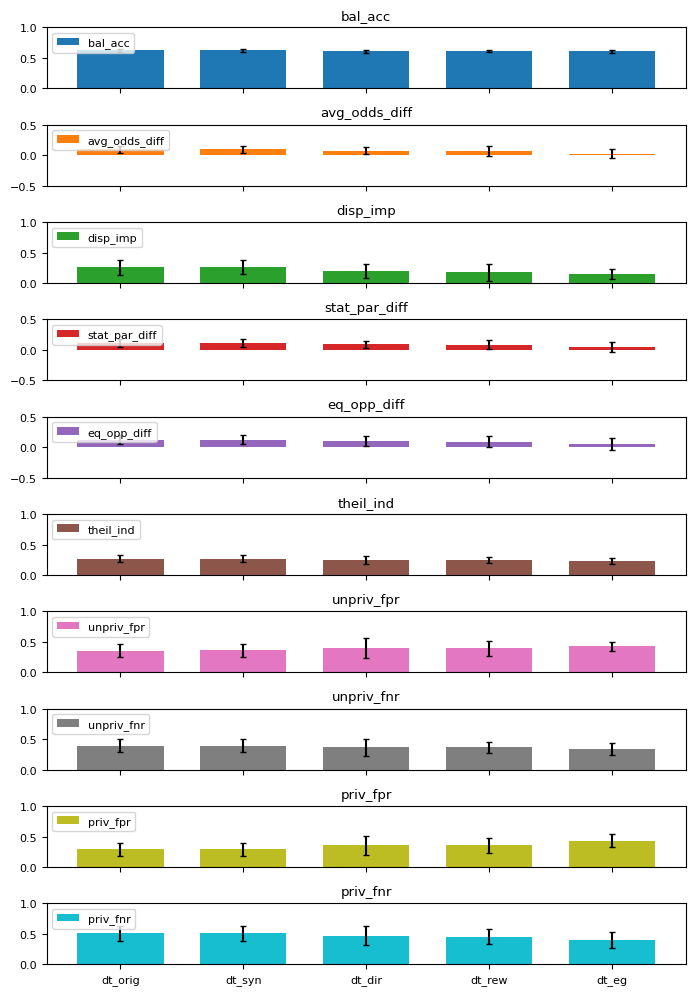

In [41]:
model_type=BASELINE
# Set up plotting options
plt.rcParams.update({'font.size': 8})  # Set global font size
pd.set_option('display.multi_sparse', False)

# Metrics and errors as lists of dictionaries
results = [orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean]
errors = [orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics]

# Classifier bias mitigators (for labels)
index = pd.Series(
    [model_type+'_orig', model_type+'_syn', model_type+'_dir', model_type+'_rew', model_type+'_eg'])

# Create DataFrame for metrics and error bars
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)

# Dynamically generate titles for all metrics in df
titles = list(df.columns)

# Plot fairness metrics with error bars
ax = df.plot.bar(
    yerr=df_error, 
    capsize=2, 
    rot=0, 
    subplots=True, 
    title=titles, 
    fontsize=8, 
    figsize=(7, 10),  # Reduced overall figure size
    legend=True,
    width=0.7  # Adjusted bar width to make bars closer
)

# Adjust Y-axis limits dynamically based on metric names
for i, subplot in enumerate(ax):
    metric = titles[i]
    if "fpr" in metric or "fnr" in metric:  # Subgroup-specific metrics
        subplot.set_ylim([0, 1])  # False positive/negative rates range from 0 to 1
    elif metric in ["bal_acc", "disp_imp", "theil_ind"]:  # General metrics
        subplot.set_ylim([0, 1])
    elif metric in ["avg_odds_diff", "stat_par_diff", "eq_opp_diff"]:  # Difference metrics
        subplot.set_ylim([-0.5, 0.5])  # Allow for negative values

    # Move legend inside the plot
    subplot.legend(loc='upper left', fontsize=8, frameon=True)

# Tight layout for better spacing
plt.tight_layout()
plt.show()

## Save Results

In [42]:
# List of method names corresponding to results/errors
method_names = ["orig", "transf", "dir", "rew", "eg"]

# Initialize a list to hold data for the DataFrame
fairness_data = []

# Populate the data list with metrics and errors
for method, metric, error in zip(method_names, results, errors):
    for key in metric.keys():
        fairness_data.append({
            "Method": method,
            "Metric": key,
            "Mean": metric[key][0],  # Assuming the metric values are single-item lists
            "Error": error[key][0]   # Assuming the error values are single-item lists
        })

# Create DataFrame from the data list
fairness_df = pd.DataFrame(fairness_data)

# File path with today's date
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./results/{ATTACK}_{DATASET}_fairness_metrics_{today}.csv"

# Save the DataFrame to CSV
fairness_df.to_csv(file_path, index=True)

print(f"File saved at: {file_path}")

File saved at: ./results/mia2_compas_race_fairness_metrics_2024-12-30.csv


## Visualization of MIA results


### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [43]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [44]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          eg_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn'] + ['dir'] + ['rew'] + ['eg'], name='Classifier MIA Attacks')
#                   + ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,
orig,0.577027,0.582062,0.585950,0.571804,0.612921
syn,0.576892,0.582336,0.585873,0.571695,0.610979
dir,0.578851,0.580869,0.589786,0.581163,0.606136
rew,0.580135,0.586447,0.583660,0.573108,0.627134
eg,0.585811,0.589407,0.593644,0.586224,0.635944


In [45]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [46]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
                       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [47]:
df_groups

,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,
orig,0.582062,0.571804,0.585950,0.612921
syn,0.582336,0.571695,0.585873,0.610979
dir,0.580869,0.581163,0.589786,0.606136
rew,0.586447,0.573108,0.583660,0.627134
eg,0.589407,0.586224,0.593644,0.635944


<Axes: xlabel='Classifier MIA Attacks'>

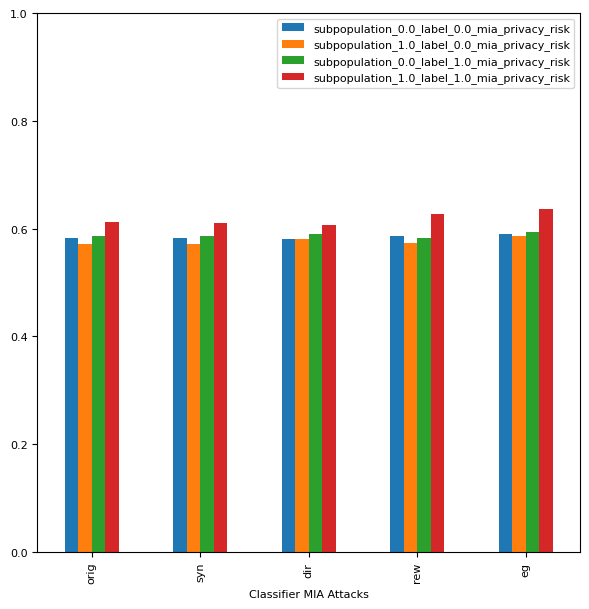

In [48]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [49]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew        eg
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.582062  0.582336  0.580869  0.586447  0.589407
subpopulation_1.0_label_0.0_mia_privacy_risk  0.571804  0.571695  0.581163  0.573108  0.586224
subpopulation_0.0_label_1.0_mia_privacy_risk  0.58595   0.585873  0.589786  0.58366   0.593644
subpopulation_1.0_label_1.0_mia_privacy_risk  0.612921  0.610979  0.606136  0.627134  0.635944


## Save Results

In [50]:
errors

[{'entire_dataset_mia_privacy_risk': 0.011680439336945831,
  'subpopulation_0.0_label_0.0_mia_privacy_risk': 0.017656000410271468,
  'subpopulation_0.0_label_1.0_mia_privacy_risk': 0.02547095349839388,
  'subpopulation_1.0_label_0.0_mia_privacy_risk': 0.02229259103822635,
  'subpopulation_1.0_label_1.0_mia_privacy_risk': 0.026738232130411762},
 {'entire_dataset_mia_privacy_risk': 0.011547199600561234,
  'subpopulation_0.0_label_0.0_mia_privacy_risk': 0.017632144967767997,
  'subpopulation_0.0_label_1.0_mia_privacy_risk': 0.02392570605144183,
  'subpopulation_1.0_label_0.0_mia_privacy_risk': 0.023435960646145323,
  'subpopulation_1.0_label_1.0_mia_privacy_risk': 0.02856258214607477},
 {'entire_dataset_mia_privacy_risk': 0.010989586887280913,
  'subpopulation_0.0_label_0.0_mia_privacy_risk': 0.022893784809309523,
  'subpopulation_0.0_label_1.0_mia_privacy_risk': 0.025001561951494698,
  'subpopulation_1.0_label_0.0_mia_privacy_risk': 0.03407076397737687,
  'subpopulation_1.0_label_1.0_mia

In [51]:
# List of method names corresponding to results/errors
method_names = ["orig", "transf", "dir", "rew", "eg"]

# Initialize a list to hold data for the DataFrame
pr_data = []

# Populate the data list with metrics and errors
for method, metric, error in zip(method_names, results, errors):
    for key in metric.keys():
        pr_data.append({
            "Method": method,
            "Metric": key,
            "Mean Privacy Risk": metric[key],  # Privacy risk mean
            "Error": error[key]               # Privacy risk error
        })

# Create DataFrame from the data list
pr_df = pd.DataFrame(pr_data)

# File path with today's date
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./results/{ATTACK}_{DATASET}_mia_privacy_risks_metrics_{today}.csv"

# Save the DataFrame to CSV
pr_df.to_csv(file_path, index=True)

print(f"File saved at: {file_path}")

File saved at: ./results/mia2_compas_race_mia_privacy_risks_metrics_2024-12-30.csv


# Main Bar Graph Visualization

In [52]:
# Subpopulations and fairness methods
subpopulations = {
    'subpopulation_0.0_label_0.0_mia_privacy_risk': "Unprivileged Unfavorable", 
    'subpopulation_0.0_label_1.0_mia_privacy_risk': "Unprivileged Favorable", 
    'subpopulation_1.0_label_0.0_mia_privacy_risk': "Privileged Unfavorable",
    'subpopulation_1.0_label_1.0_mia_privacy_risk': "Privileged Favorable"
}

fairness_methods = ["syn", "dir", "rew", "eg"]

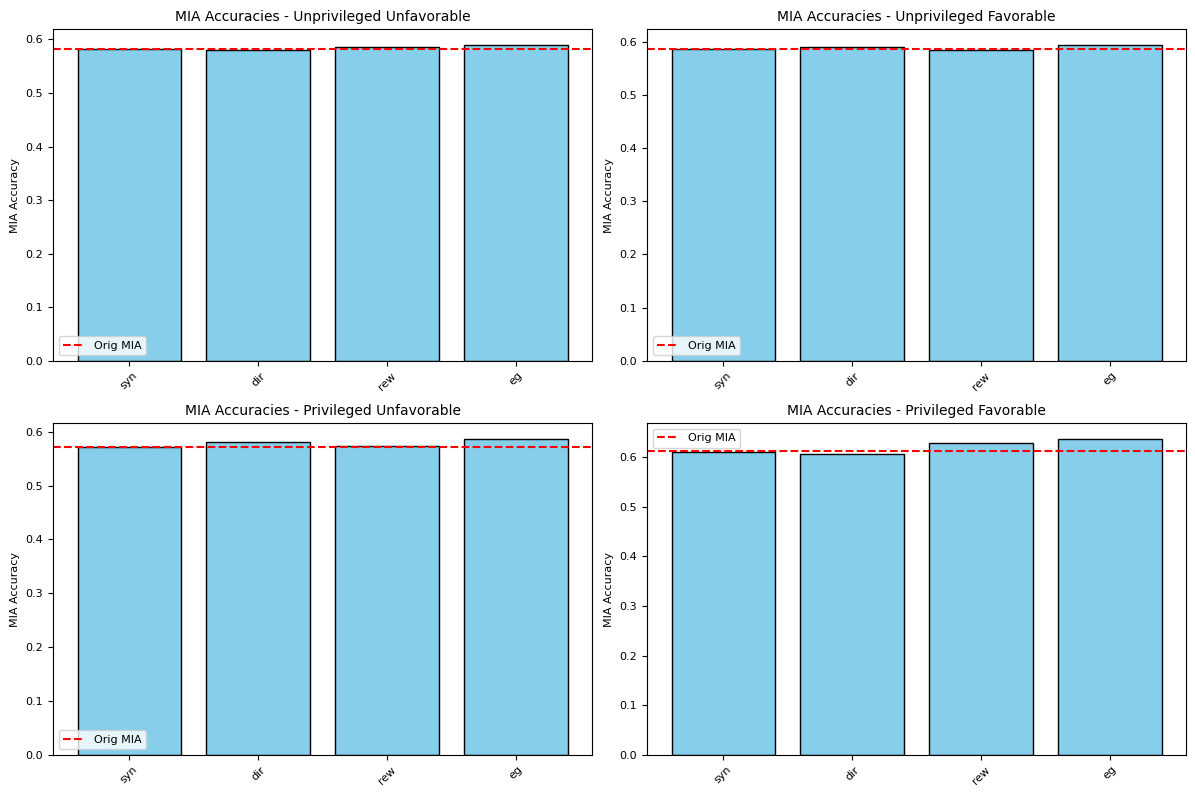

In [53]:
# Combine results into a list
all_results = [
    transf_mia_metrics_mean,
    dir_mia_metrics_mean,
    reweigh_mia_metrics_mean,
    eg_mia_metrics_mean
]

# Organize data for plotting
data = {subpopulations[key]: [results[key] for results in all_results] for key in subpopulations.keys()}
orig_values = orig_mia_metrics_mean

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
idx = 0

for key, value in subpopulations.items():
    accuracies = data[value]
    ax = axes[idx]
    
    # Plot bar chart (excluding 'orig')
    ax.bar(fairness_methods, accuracies, color='skyblue', edgecolor='black')
    
    # Add dashed line for 'orig' MIA accuracy
    ax.axhline(orig_values[key], color='red', linestyle='--', label='Orig MIA')
    
    # Title and labels
    ax.set_title(f"MIA Accuracies - {value}", fontsize=10)
    ax.set_ylabel("MIA Accuracy")
    ax.set_xticks(np.arange(len(fairness_methods)))
    ax.set_xticklabels(fairness_methods, rotation=45)
    ax.legend()
    
    idx = idx + 1

plt.tight_layout()
plt.show()

### Visualizing using novel technique

In [54]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [55]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in eg_mia_error_metrics.keys():
    for val in eg_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["eg", key.replace("_mia_attacker_advantage", ""), val])

In [56]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.577703
1,orig,entire_dataset_mia_privacy_risk,0.574324
2,orig,entire_dataset_mia_privacy_risk,0.560135
3,orig,entire_dataset_mia_privacy_risk,0.595270
4,orig,entire_dataset_mia_privacy_risk,0.577027
...,...,...,...
495,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.597024
496,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.656250
497,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.624573
498,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.643433


In [57]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.577703
1,orig,entire_dataset_mia_privacy_risk,0.574324
2,orig,entire_dataset_mia_privacy_risk,0.560135
3,orig,entire_dataset_mia_privacy_risk,0.595270
4,orig,entire_dataset_mia_privacy_risk,0.577027
...,...,...,...
495,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.597024
496,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.656250
497,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.624573
498,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.643433


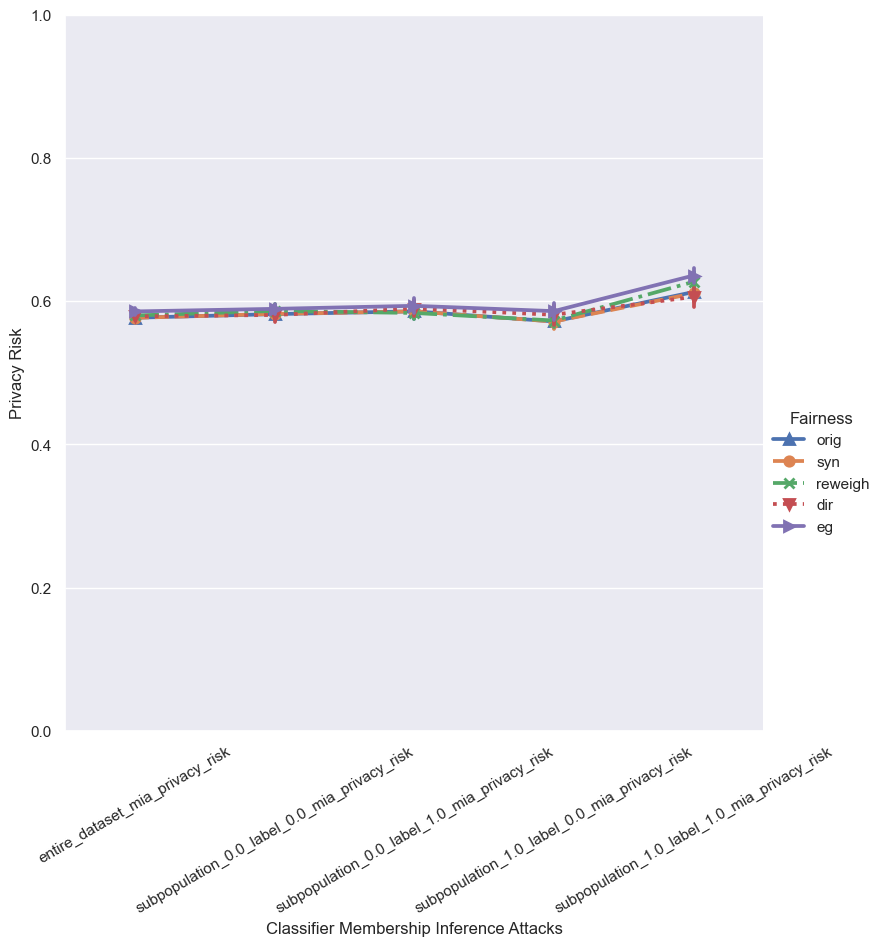

In [58]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [59]:
from sklearn.metrics import RocCurveDisplay, auc

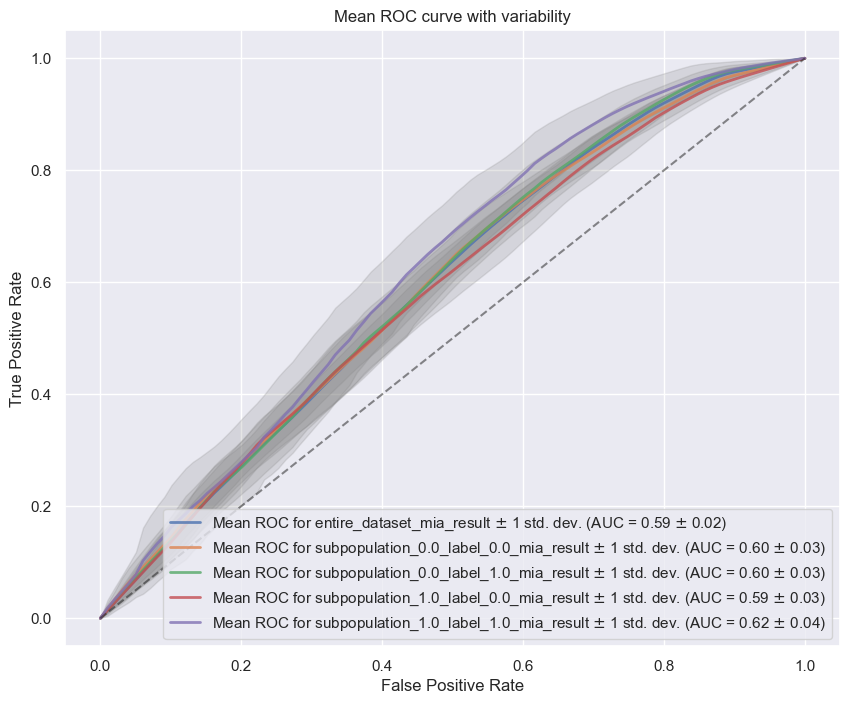

In [60]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", 
            "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", 
            "subpopulation_1.0_label_0.0_mia_result",
            "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.60
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.85
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.16
  Positive predictive value: 0.60
  Optimal thershold: [0.8873032]
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.60
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.60
  Test Accuracy (TNR): 0.55
  Attacker advantage: 0.15
  Positive predictive value: 0.58
  Optimal thershold: [0.45953233]
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.58
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.43
  Attacker advantage: 0.12
  Positive predictive value: 0.58
  Optimal thershold: [0.55961579]
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.61
  Privacy Risk: 0.60
  Accuracy: 0.60
  Train Acc

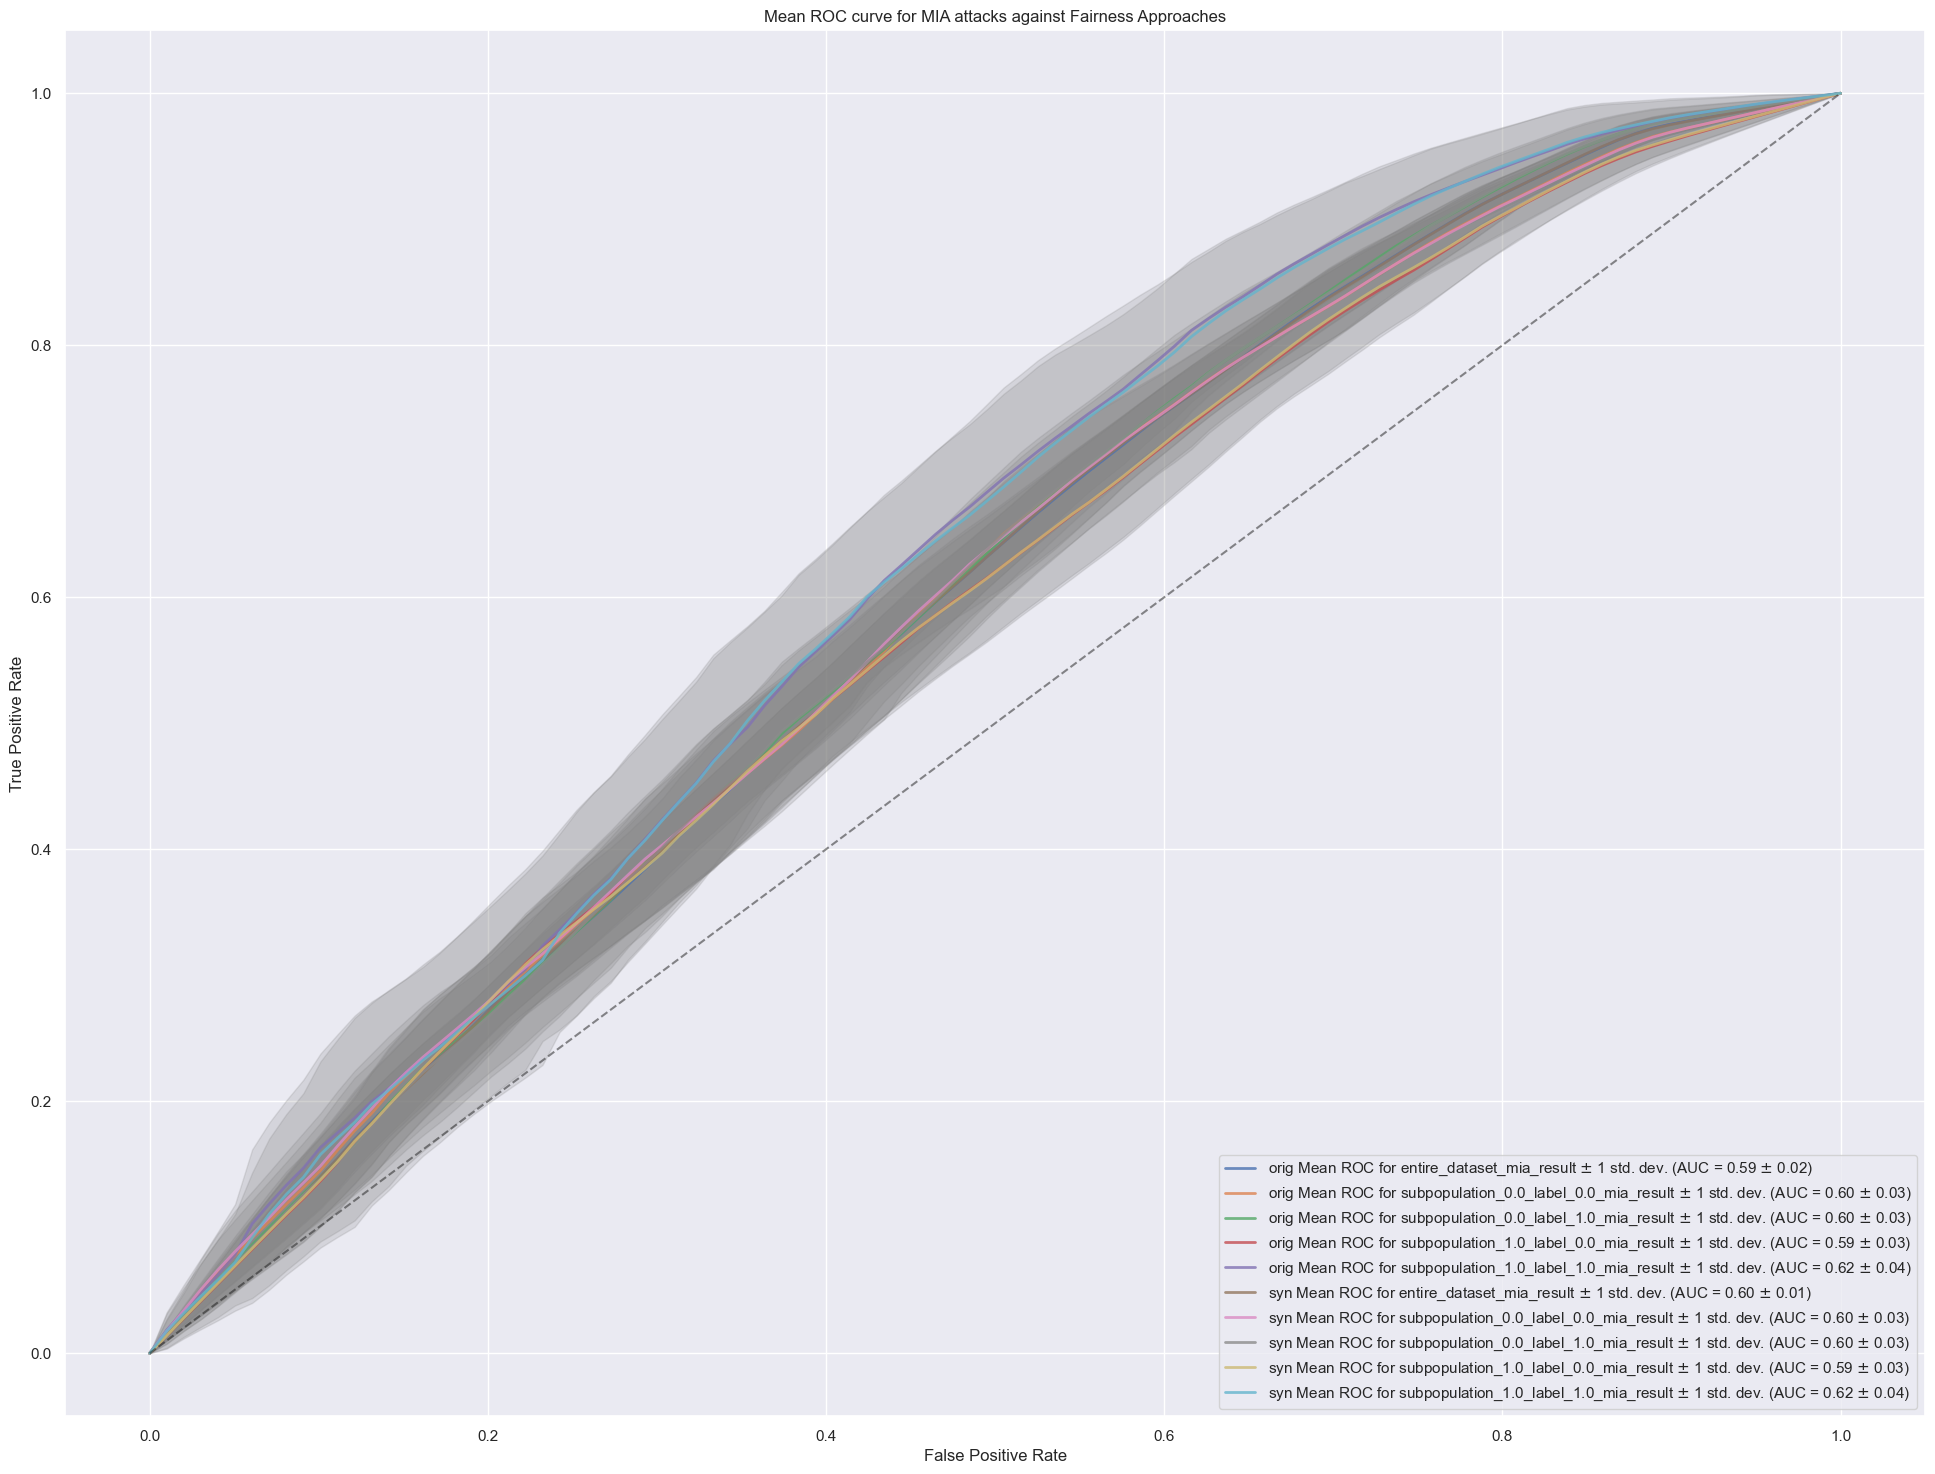

In [61]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics], ["orig", "syn"]): 
#                               dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", 
                "subpopulation_0.0_label_0.0_mia_result",
                "subpopulation_0.0_label_1.0_mia_result", 
                "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            print(mia_res)
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        print(tprs)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

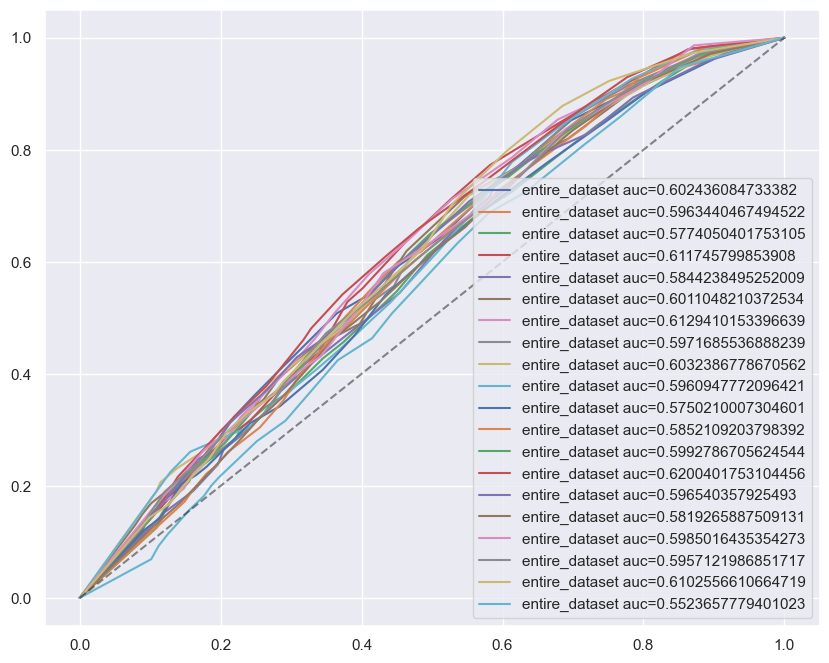

In [62]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [63]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("mia_auc")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("mia_auc")}

In [64]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_auc,subpopulation_0.0_label_0.0_mia_auc,subpopulation_0.0_label_1.0_mia_auc,subpopulation_1.0_label_0.0_mia_auc,subpopulation_1.0_label_1.0_mia_auc
Classifier MIA Attacks,,,,,
orig,0.594888,0.595313,0.598014,0.585993,0.621987
syn,0.595106,0.596224,0.597967,0.586291,0.620062
dir,0.595900,0.594129,0.595366,0.593367,0.620276
rew,0.597785,0.601249,0.593171,0.581467,0.638963
egr,0.605570,0.605739,0.606685,0.600338,0.649702


<Axes: xlabel='Classifier MIA Attacks'>

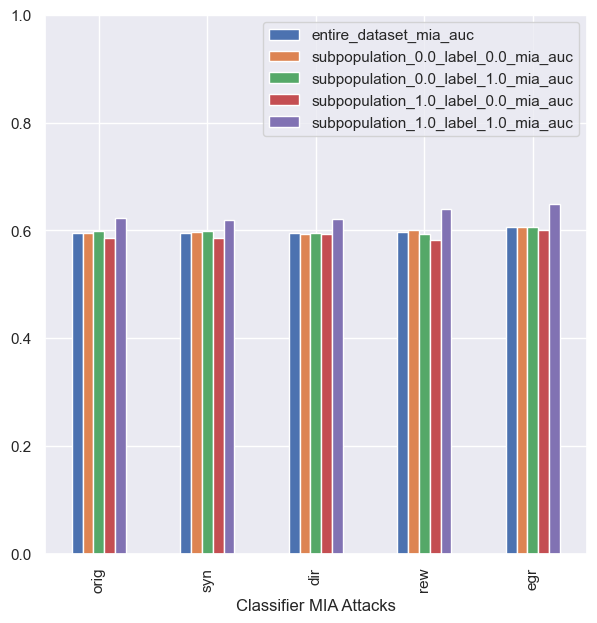

In [65]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [66]:
# Creating data structures to plot point categorical plot from seaborn

In [67]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [68]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.15540540540540537],
 ['orig', 'entire_dataset', 0.14864864864864863],
 ['orig', 'entire_dataset', 0.12027027027027026],
 ['orig', 'entire_dataset', 0.19054054054054048],
 ['orig', 'entire_dataset', 0.15405405405405415],
 ['orig', 'entire_dataset', 0.1702702702702703],
 ['orig', 'entire_dataset', 0.1837837837837838],
 ['orig', 'entire_dataset', 0.15810810810810816],
 ['orig', 'entire_dataset', 0.16621621621621618],
 ['orig', 'entire_dataset', 0.16486486486486496],
 ['orig', 'entire_dataset', 0.11891891891891893],
 ['orig', 'entire_dataset', 0.1351351351351351],
 ['orig', 'entire_dataset', 0.1527027027027027],
 ['orig', 'entire_dataset', 0.1783783783783784],
 ['orig', 'entire_dataset', 0.15540540540540537],
 ['orig', 'entire_dataset', 0.1351351351351352],
 ['orig', 'entire_dataset', 0.14864864864864863],
 ['orig', 'entire_dataset', 0.14459459459459456],
 ['orig', 'entire_dataset', 0.19324324324324327],
 ['orig', 'entire_dataset', 0.10675675675675678],
 ['ori

In [69]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

,Fairness,MIA,attacker_advantage
0,orig,entire_dataset,0.155405
1,orig,entire_dataset,0.148649
2,orig,entire_dataset,0.120270
3,orig,entire_dataset,0.190541
4,orig,entire_dataset,0.154054
...,...,...,...
495,egr,subpopulation_1.0_label_1.0,0.200298
496,egr,subpopulation_1.0_label_1.0,0.312500
497,egr,subpopulation_1.0_label_1.0,0.249146
498,egr,subpopulation_1.0_label_1.0,0.286867


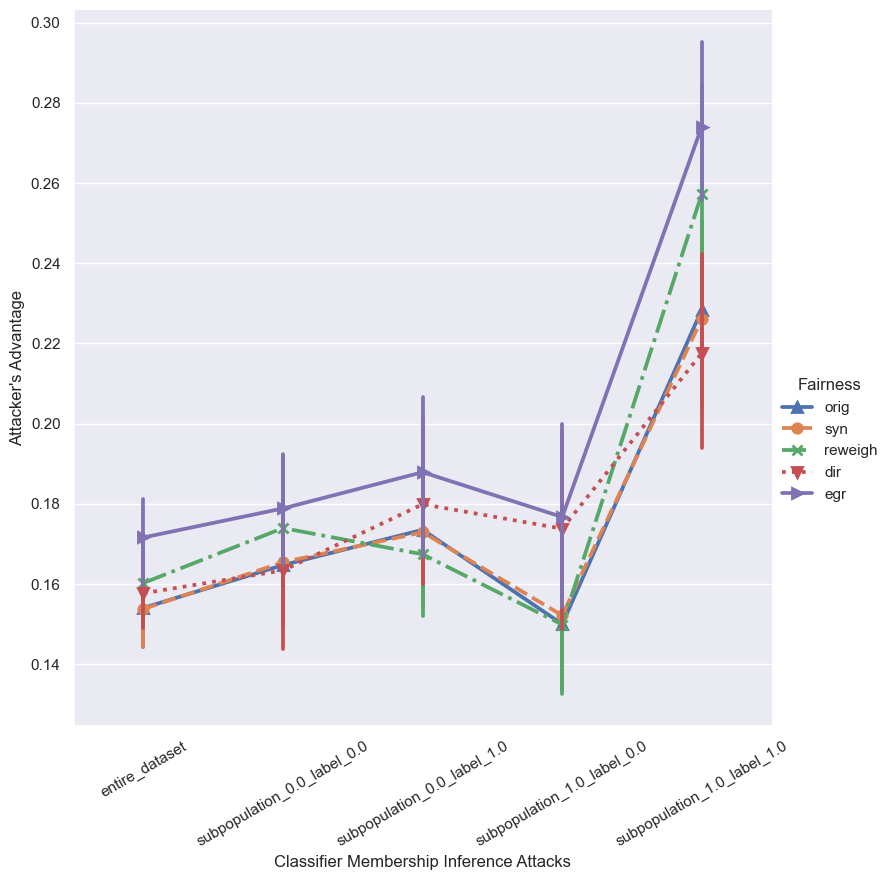

In [70]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


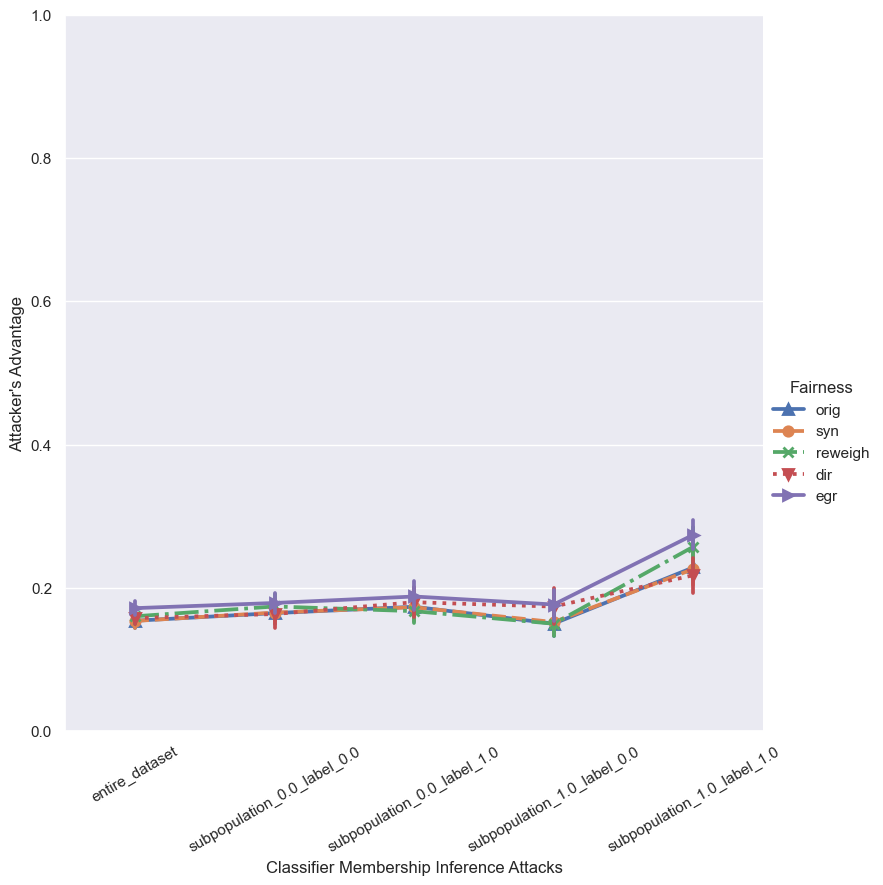

In [71]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [72]:
pd.DataFrame(orig_mia_metrics_att_ad)

,entire_dataset_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
0,0.155405,0.162511,0.160643,0.136561,0.308251
1,0.148649,0.149016,0.152048,0.199887,0.216667
2,0.120270,0.116970,0.115856,0.108337,0.223485
3,0.190541,0.120924,0.246391,0.208965,0.236068
4,0.154054,0.181492,0.124116,0.122312,0.242593
5,0.170270,0.240329,0.134347,0.152522,0.250429
6,0.183784,0.196282,0.224000,0.139538,0.184818
7,0.158108,0.174330,0.206996,0.122085,0.279662
8,0.166216,0.183143,0.168402,0.096044,0.220508
9,0.164865,0.203851,0.181280,0.150632,0.245474


In [73]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [74]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
Classifier MIA Attacks,,,,,
orig,0.154054,0.164732,0.173526,0.150009,0.228451
syn,0.153784,0.165443,0.172919,0.152179,0.226193
dir,0.157703,0.163389,0.179904,0.173809,0.217601
rew,0.160270,0.173959,0.167418,0.149878,0.257349
egr,0.171622,0.178858,0.187896,0.176713,0.274083


<Axes: xlabel='Classifier MIA Attacks'>

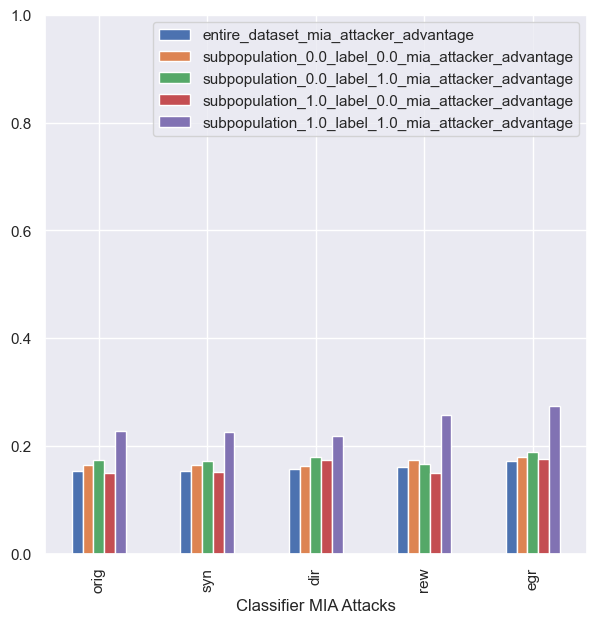

In [75]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [76]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("mia_ppv")}

In [77]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.5965909090909091],
 ['orig', 'entire_dataset', 0.5845824411134903],
 ['orig', 'entire_dataset', 0.5815602836879433],
 ['orig', 'entire_dataset', 0.5836065573770493],
 ['orig', 'entire_dataset', 0.5648414985590778],
 ['orig', 'entire_dataset', 0.6271186440677966],
 ['orig', 'entire_dataset', 0.5906976744186045],
 ['orig', 'entire_dataset', 0.592436974789916],
 ['orig', 'entire_dataset', 0.6428571428571429],
 ['orig', 'entire_dataset', 0.6360153256704981],
 ['orig', 'entire_dataset', 0.5859375],
 ['orig', 'entire_dataset', 0.5644891122278056],
 ['orig', 'entire_dataset', 0.5990990990990991],
 ['orig', 'entire_dataset', 0.6083650190114068],
 ['orig', 'entire_dataset', 0.5965909090909091],
 ['orig', 'entire_dataset', 0.5622950819672131],
 ['orig', 'entire_dataset', 0.6057692307692307],
 ['orig', 'entire_dataset', 0.611353711790393],
 ['orig', 'entire_dataset', 0.5921787709497206],
 ['orig', 'entire_dataset', 0.5420660276890309],
 ['orig', 'subpopulation_0.0_la

In [78]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

,Fairness,MIA,PPV
0,orig,entire_dataset,0.596591
1,orig,entire_dataset,0.584582
2,orig,entire_dataset,0.581560
3,orig,entire_dataset,0.583607
4,orig,entire_dataset,0.564841
...,...,...,...
495,egr,subpopulation_1.0_label_1.0,0.666667
496,egr,subpopulation_1.0_label_1.0,1.000000
497,egr,subpopulation_1.0_label_1.0,0.710526
498,egr,subpopulation_1.0_label_1.0,0.750000


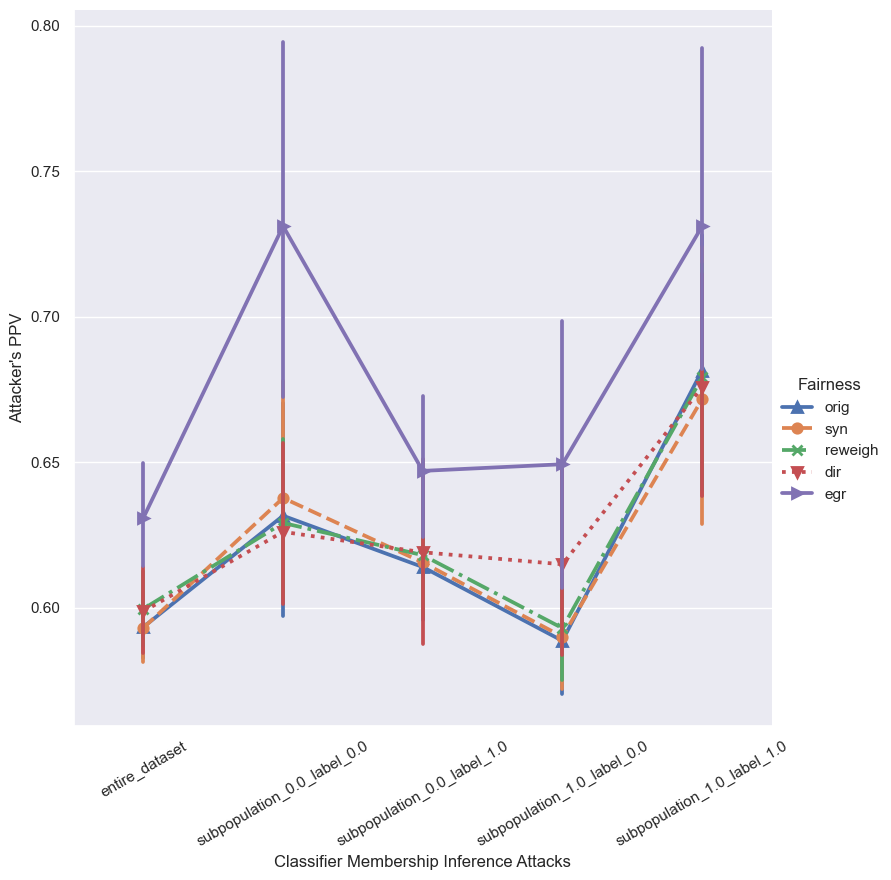

In [79]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )
